In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from shapely.geometry import Point
import os
import json

In [52]:
df=pd.read_csv('Measurement_summary.csv')

In [53]:
df=pd.DataFrame(df)

In [54]:
df.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [55]:
df.shape

(647511, 11)

In [56]:
df.describe()

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995
std,7.211315,0.053273,0.078790,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595
min,101.000000,37.452357,126.835151,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000
max,125.000000,37.658774,127.136792,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


From the statistics summary of the data we see weird indications on every pollutant with -1 value. We decide to plot the distribution of all of them so we can quantify the amount of those values for each and if there are somehow interconnected. Those values are probably missing values imputed with -1 for indication.

In [57]:
pollutants=df.iloc[:,5:]

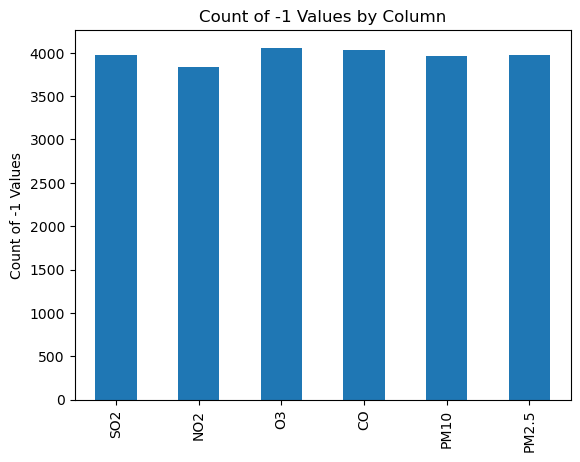

In [58]:
# Identify and visualize the count of `-1` values in each column
negative_values = (pollutants == -1).sum()
negative_values.plot(kind='bar', title="Count of -1 Values by Column")
plt.ylabel("Count of -1 Values");

Most of the pollutants have near 4k rows with -1 values compared to the 650k of the dataset, making it difficult to recognise from a histogram due large proportional difference.

In [59]:
# Convert 'Measurement date' to datetime for temporal analysis
df['Measurement date'] = pd.to_datetime(df['Measurement date'])

In [60]:
# Group the data to count `-1` values by date for each pollutant
grouped_data = {}
for column in pollutants.columns:
    grouped_data[column] = df[df[column] == -1].groupby(df['Measurement date'].dt.date).size()

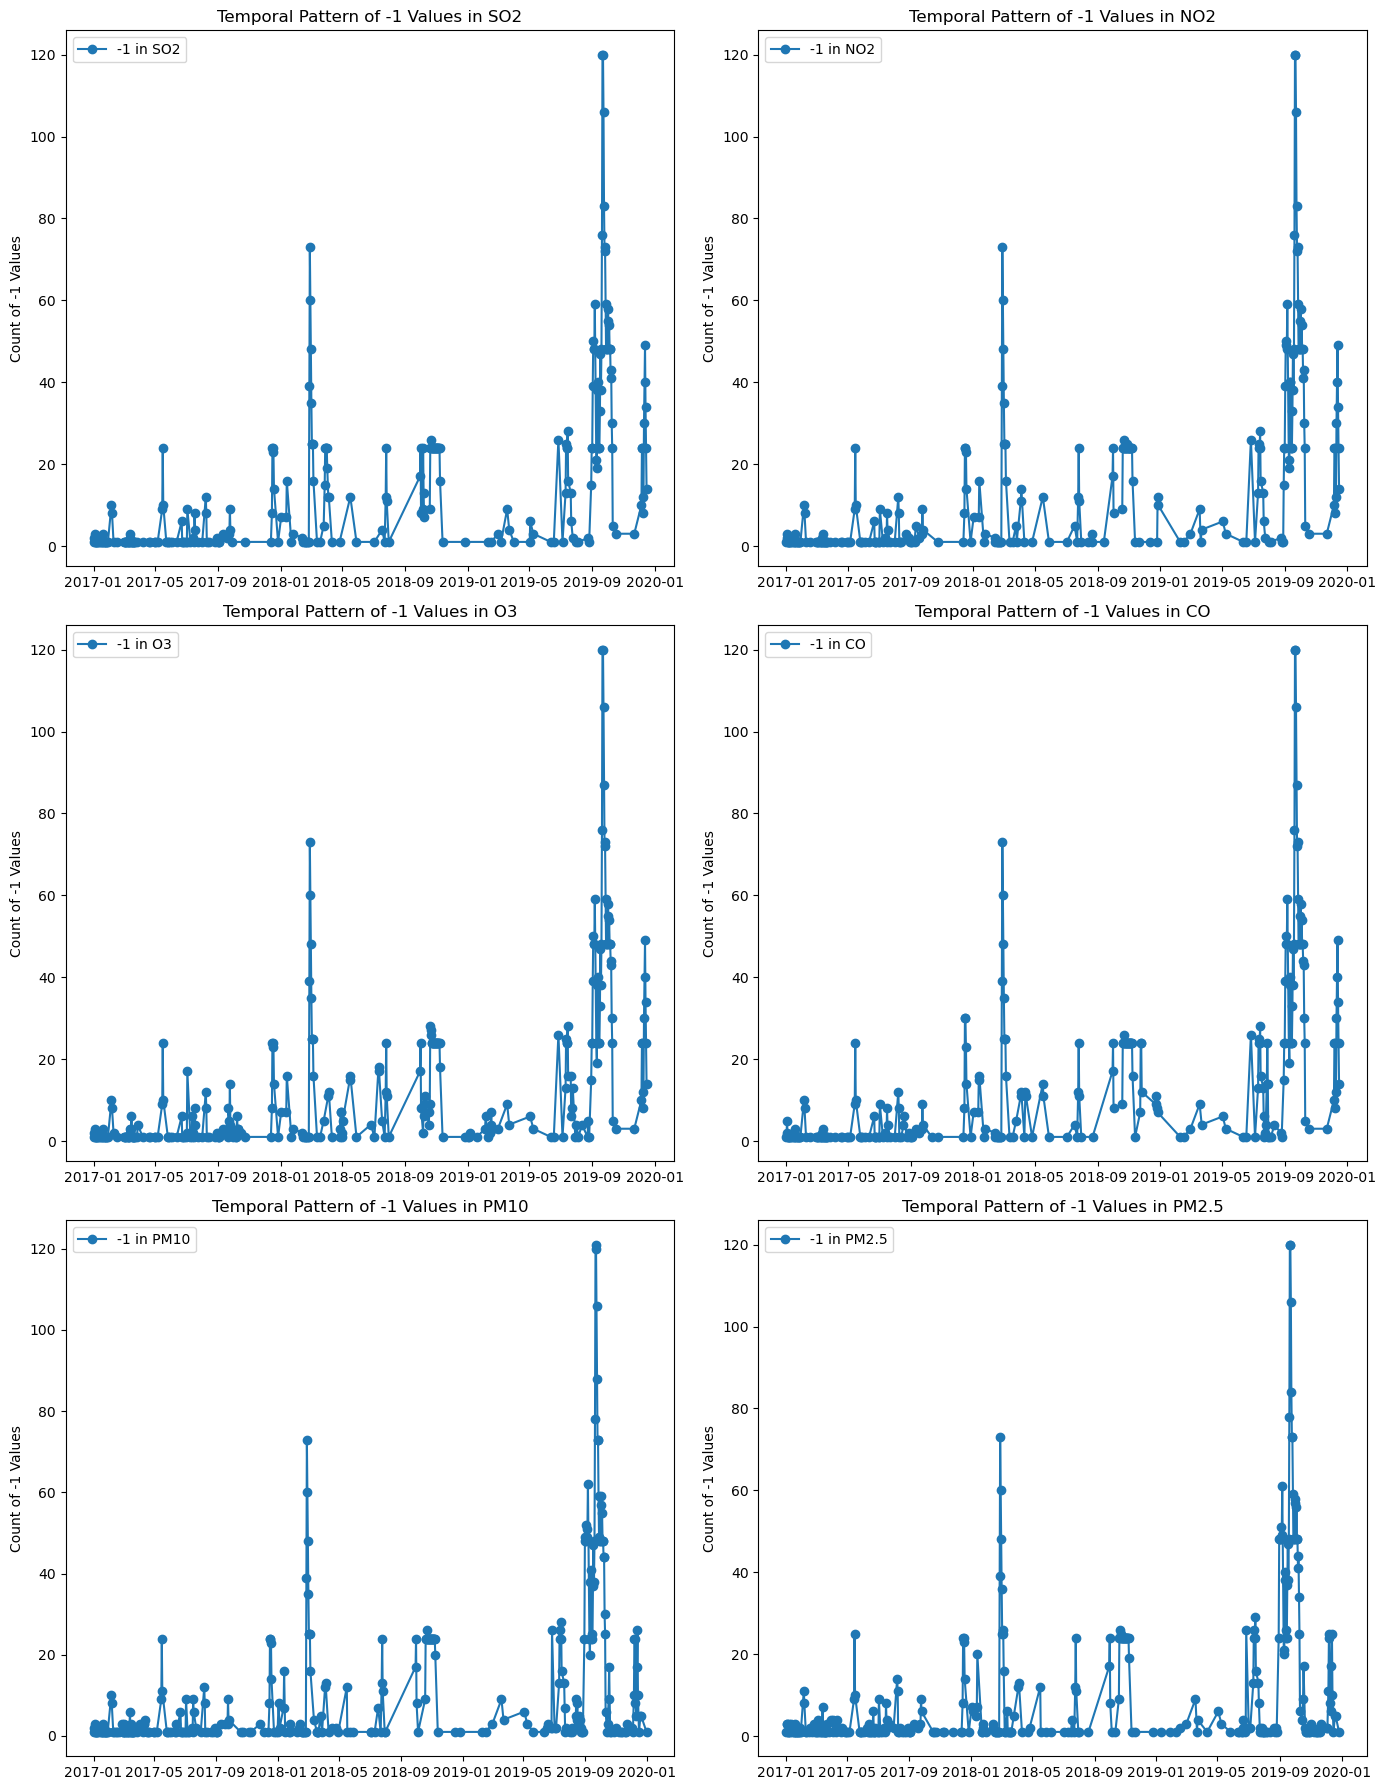

In [61]:
# Visualize spatial or temporal patterns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

axes = axes.flatten()
# Plot each pollutant in its respective subplot
for idx, column in enumerate(pollutants.columns):
    ax = axes[idx]
    ax.plot(grouped_data[column], marker='o', linestyle='-', label=f'-1 in {column}')
    ax.set_title(f"Temporal Pattern of -1 Values in {column}")
    ax.set_ylabel("Count of -1 Values")
    ax.legend()

plt.tight_layout();

We can see the missing values (-1) are very identical throughout every pollutant, suggesting the measurement instruments for each pollutant are not operating individually

We like to analyze if there are any particular stations that have produced more problemtic metrics for future improvements

In [62]:
current_directory = os.getcwd()
print(r"Current Directory:", current_directory)

Current Directory: C:\Users\elias\OneDrive\Documents\MSc Data Science\INM433 Visual Analytics\Pair Coursework\AirPollutionSeoul


In [63]:
current_directory = os.getcwd().replace("\\", "/")
print("Current Directory:", current_directory)

Current Directory: C:/Users/elias/OneDrive/Documents/MSc Data Science/INM433 Visual Analytics/Pair Coursework/AirPollutionSeoul


In [64]:
# Download GeoJSON data for Seoul districts (replace URL with an appropriate file if needed)
geojson_path = '/Users/elias/OneDrive/Documents/MSc Data Science/INM433 Visual Analytics/Pair Coursework/AirPollutionSeoul/seoul_municipalities_geo.json'

In [65]:
with open(geojson_path, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

In [66]:
# Calculate total `-1` values for each station
station_total_negative_values = df.groupby('Station code')[pollutants.columns].apply(lambda x: (x == -1).sum().sum())

# Merge with spatial coordinates for plotting
station_coordinates = df.groupby('Station code')[['Latitude', 'Longitude']].first()
station_data = station_total_negative_values.to_frame('Total -1 Values').merge(station_coordinates, left_index=True, right_index=True)

In [67]:
# Create a Folium map centered on Seoul
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=12)

In [68]:
# Add district boundaries to the map
folium.GeoJson(
    geojson_data,
    name='District Boundaries',
    style_function=lambda x: {
        'fillColor': 'orange',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.2,
    },
).add_to(seoul_map)

In [69]:
# Add station markers directly to the map
for idx, row in station_data.iterrows():
    folium.CircleMarker(
        location=(row['Latitude'], row['Longitude']),
        radius=row['Total -1 Values'] ** 0.5,  # Scale circle size
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        tooltip=f"Station Code: {idx}<br>Total -1 Values: {row['Total -1 Values']}",
    ).add_to(seoul_map)

# Add layer control
folium.LayerControl().add_to(seoul_map)

# Display the map
seoul_map

From the map while we can easily identify stations with much higher missing value rate. Location-wise there is no clear area where we see those stations, ust spread across the city.

In [70]:
df.head()

,Measurement date,Station code,Address,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 01:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2017-01-01 02:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2017-01-01 03:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2017-01-01 04:00:00,101,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0


In [71]:
# Ensure pollutant columns are numeric
for col in pollutants.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace -1 with NaN for proper handling
df[pollutants.columns] = df[pollutants.columns].replace(-1, pd.NA)

# Create a mask to identify missing values before interpolation
imputed_mask = df[pollutants.columns].isna()

In [72]:
# Apply linear interpolation (or your chosen interpolation method)
for col in pollutants.columns:
    df[col] = df[col].interpolate(method='linear', axis=0)  # Change method if needed

C:\Users\elias\AppData\Local\Temp\ipykernel_22324\2107263874.py:3: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df[col] = df[col].interpolate(method='linear', axis=0)  # Change method if needed


In [73]:
# Mark imputed values after interpolation
imputed_values = imputed_mask & df[pollutants.columns].notna()

TypeError: float() argument must be a string or a real number, not 'NAType'

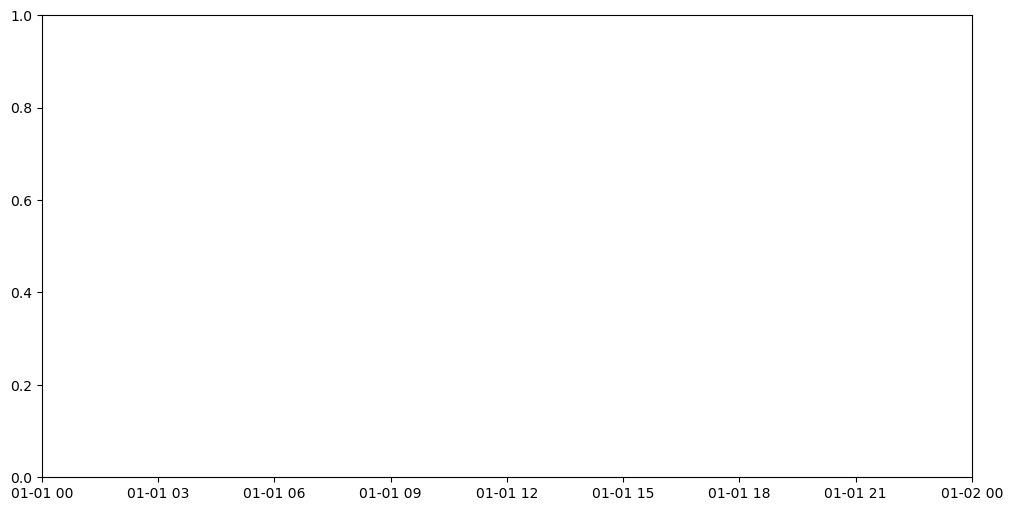

In [74]:
# Visualization for a single column (e.g., 'SO2')
column_to_plot = 'SO2'
plt.figure(figsize=(12, 6))
plt.plot(df['Measurement date'], df[column_to_plot], label='Original/Interpolated Values', alpha=0.7)
plt.scatter(
    df['Measurement date'][imputed_values[column_to_plot]],
    df[column_to_plot][imputed_values[column_to_plot]],
    color='red',
    label='Imputed Values',
    s=10
)
plt.title(f"Linear Interpolation for {column_to_plot}")
plt.xlabel("Date")
plt.ylabel(column_to_plot)
plt.legend()
plt.tight_layout()

In [50]:
# Mark imputed values after interpolation
imputed_values = imputed_mask & df[pollutants.columns].notna()

TypeError: float() argument must be a string or a real number, not 'NAType'

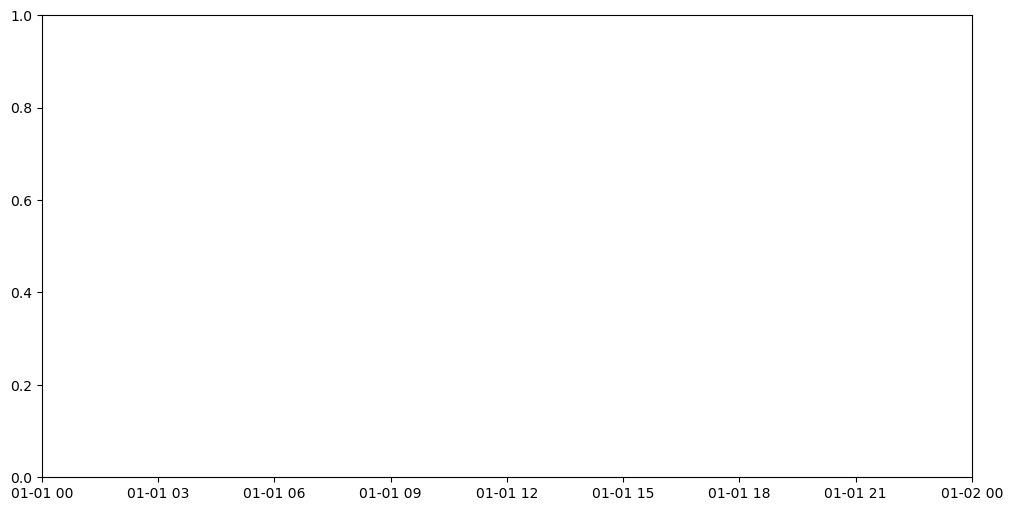

In [51]:
# Visualize for a single column (e.g., 'SO2')
column_to_plot = 'SO2'
plt.figure(figsize=(12, 6))
plt.plot(df['Measurement date'], df[column_to_plot], label='Original/Interpolated Values', alpha=0.7)
plt.scatter(
    df['Measurement date'][imputed_values[column_to_plot]],
    df[column_to_plot][imputed_values[column_to_plot]],
    color='red',
    label='Imputed Values',
    s=10
)
plt.title(f"Linear Interpolation for {column_to_plot}")
plt.xlabel("Date")
plt.ylabel(column_to_plot)
plt.legend()
plt.tight_layout()

In [ ]:
# Visualize for all pollutants
for column in pollutants.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(df['Measurement date'], df[column], label='Original/Interpolated Values', alpha=0.7)
    plt.scatter(
        df['Measurement date'][imputed_values[column]],
        df[column][imputed_values[column]],
        color='red',
        label='Imputed Values',
        s=10
    )
    plt.title(f"Linear Interpolation for {column}")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.tight_layout()
    plt.show()

After capping the outliers we see an unwanted spike at the largest limit of most of the pollutants, especially visible on the PM10 and PM2.5 pollutants. S we decide to choose interpolation for handling the outliers

In [ ]:
# Ensure pollutant columns are numeric
for col in pollutants.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
# Function to detect outliers using the IQR method
def detect_outliers(data, columns):
    outlier_mask = pd.DataFrame(False, index=data.index, columns=columns)
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask[col] = (data[col] < lower_bound) | (data[col] > upper_bound)
    return outlier_mask

In [ ]:
# Detect outliers in pollutant columns
outlier_mask = detect_outliers(df, pollutants.columns)

# Mark outliers as NaN for interpolation
df[pollutants.columns] = df[pollutants.columns].mask(outlier_mask)

# Apply linear interpolation to handle outliers
df[pollutants.columns] = df[pollutants.columns].interpolate(method='linear', axis=0)

In [ ]:
# Visualize results for one column (e.g., 'SO2')
column_to_plot = 'SO2'
plt.figure(figsize=(12, 6))
plt.plot(df['Measurement date'], df[column_to_plot], label='Original/Interpolated Values', alpha=0.7)
plt.scatter(
    df['Measurement date'][outlier_mask[column_to_plot]],
    df[column_to_plot][outlier_mask[column_to_plot]],
    color='red',
    label='Outliers (Interpolated)',
    s=10
)
plt.title(f"Interpolation for Outliers in {column_to_plot}")
plt.xlabel("Date")
plt.ylabel(column_to_plot)
plt.legend()
plt.tight_layout()

In [ ]:
# Plot histograms for all pollutants
plt.figure(figsize=(16, 12))

for idx, column in enumerate(pollutants.columns, start=1):
    plt.subplot(len(pollutants.columns) // 2 + len(pollutants.columns) % 2, 2, idx)
    plt.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(f"Histogram for {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
# Impute NaN values with the mean of each column
for col in pollutants.columns:
    df[col] = df[col].fillna(df[col].mean())

In [ ]:
df.isnull().sum()

In [ ]:
# Export the preprocessed dataset to a CSV file
output_file_path = "Preprocessed_Dataset.csv"
df.to_csv(output_file_path, index=False)

In [ ]:
df.head()

In [ ]:
df.describe()